여기서는 SDXL 모델을 inferentia2 인스턴스에 deploy하는 방법에 대한 예제 코드를 설명합니다.

1) 먼저, ec2에서 inferentia2 인스턴스를 활성화합니다. 참고로 본 문서의 작성자는 inf2.24xlarge 를 활성화하였습니다.

2) 활성화된 인스턴스에서 사전 세팅 작업을 진행합니다. 

In [1]:
%env TOKENIZERS_PARALLELISM=True #Supresses tokenizer warnings making errors easier to detect
%pip install diffusers==0.20.2 transformers==4.33.1 accelerate==0.22.0 safetensors==0.3.1 matplotlib

env: TOKENIZERS_PARALLELISM=True #Supresses tokenizer warnings making errors easier to detect


Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
os.environ["NEURON_FUSE_SOFTMAX"] = "1"

import torch
import torch.nn as nn
import torch_neuronx
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import time
import copy
from IPython.display import clear_output

from diffusers import StableDiffusionXLPipeline, DiffusionPipeline, DPMSolverMultistepScheduler
from diffusers.models.unet_2d_condition import UNet2DConditionOutput
from transformers.models.clip.modeling_clip import CLIPTextModelOutput
# Compatibility for diffusers<0.18.0
from packaging import version
import diffusers
diffusers_version = version.parse(diffusers.__version__)
use_new_diffusers = diffusers_version >= version.parse('0.18.0')
if use_new_diffusers:
    from diffusers.models.attention_processor import Attention
else:
    from diffusers.models.cross_attention import CrossAttention

# Define datatype
DTYPE = torch.float32

In [3]:
def get_attention_scores_neuron(self, query, key, attn_mask):    
    if(query.size() == key.size()):
        attention_scores = custom_badbmm(
            key,
            query.transpose(-1, -2),
            self.scale
        )
        attention_probs = attention_scores.softmax(dim=1).permute(0,2,1)

    else:
        attention_scores = custom_badbmm(
            query,
            key.transpose(-1, -2),
            self.scale
        )
        attention_probs = attention_scores.softmax(dim=-1)
  
    return attention_probs
 

def custom_badbmm(a, b, scale):
    bmm = torch.bmm(a, b)
    scaled = bmm * scale
    return scaled
 

class UNetWrap(nn.Module):
    def __init__(self, unet):
        super().__init__()
        self.unet = unet
 
    def forward(self, sample, timestep, encoder_hidden_states, text_embeds=None, time_ids=None):
        out_tuple = self.unet(sample,
                              timestep,
                              encoder_hidden_states,
                              added_cond_kwargs={"text_embeds": text_embeds, "time_ids": time_ids},
                              return_dict=False)
        return out_tuple
    
    
class NeuronUNet(nn.Module):
    def __init__(self, unetwrap):
        super().__init__()
        self.unetwrap = unetwrap
        self.config = unetwrap.unet.config
        self.in_channels = unetwrap.unet.in_channels
        self.add_embedding = unetwrap.unet.add_embedding
        self.device = unetwrap.unet.device
 
    def forward(self, sample, timestep, encoder_hidden_states, added_cond_kwargs=None, return_dict=False, cross_attention_kwargs=None):
        sample = self.unetwrap(sample,
                               timestep.float().expand((sample.shape[0],)),
                               encoder_hidden_states,
                               added_cond_kwargs["text_embeds"],
                               added_cond_kwargs["time_ids"])[0]
        return UNet2DConditionOutput(sample=sample)
    

class TextEncoderOutputWrapper(nn.Module):
    def __init__(self, traceable_text_encoder, original_text_encoder):
        super().__init__()
        self.traceable_text_encoder = traceable_text_encoder
        self.config = original_text_encoder.config
        self.dtype = original_text_encoder.dtype
        self.device = original_text_encoder.device

    def forward(self, text_input_ids, output_hidden_states=True):
        out_tuple = self.traceable_text_encoder(text_input_ids)
        return CLIPTextModelOutput(text_embeds=out_tuple[0], last_hidden_state=out_tuple[1], hidden_states=out_tuple[2])
    
class TraceableTextEncoder(nn.Module):
    def __init__(self, text_encoder):
        super().__init__()
        self.text_encoder = text_encoder

    def forward(self, text_input_ids):
        out_tuple = self.text_encoder(text_input_ids, output_hidden_states=True, return_dict=False)
        return out_tuple

In [4]:
COMPILER_WORKDIR_ROOT = 'sdxl_compile_dir_1024'

# Model ID for SD XL version pipeline
model_id = "stabilityai/stable-diffusion-xl-base-1.0"

# --- Compile Text Encoders and save ---

pipe = StableDiffusionXLPipeline.from_pretrained(model_id, torch_dtype=torch.float32)


# Apply wrappers to make text encoders traceable
traceable_text_encoder = copy.deepcopy(TraceableTextEncoder(pipe.text_encoder))
traceable_text_encoder_2 = copy.deepcopy(TraceableTextEncoder(pipe.text_encoder_2))

del pipe

text_input_ids_1 = torch.tensor([[49406,   736,  1615, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407]])


text_input_ids_2 = torch.tensor([[49406,   736,  1615, 49407,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]])


# Text Encoder 1
neuron_text_encoder = torch_neuronx.trace(
    traceable_text_encoder,
    text_input_ids_1,
    compiler_workdir=os.path.join(COMPILER_WORKDIR_ROOT, 'text_encoder'),
)

text_encoder_filename = os.path.join(COMPILER_WORKDIR_ROOT, 'text_encoder/model.pt')
torch.jit.save(neuron_text_encoder, text_encoder_filename)


# Text Encoder 2
neuron_text_encoder_2 = torch_neuronx.trace(
    traceable_text_encoder_2,
    text_input_ids_2,
    compiler_workdir=os.path.join(COMPILER_WORKDIR_ROOT, 'text_encoder_2'),
)

text_encoder_2_filename = os.path.join(COMPILER_WORKDIR_ROOT, 'text_encoder_2/model.pt')
torch.jit.save(neuron_text_encoder_2, text_encoder_2_filename)

# --- Compile VAE decoder and save ---
# Only keep the model being compiled in RAM to minimze memory pressure
pipe = StableDiffusionXLPipeline.from_pretrained(model_id, torch_dtype=torch.float32, low_cpu_mem_usage=True)
decoder = copy.deepcopy(pipe.vae.decoder)

del pipe

# # Compile vae decoder
bucket_sizes = [(64, 64), (128, 128)]
decoder_neuron_buckets = {}
for bucket_size in bucket_sizes:    
    h, w = bucket_size
    decoder_in = torch.randn([1, 4, h, w])
    decoder_neuron = torch_neuronx.trace(
        decoder, 
        decoder_in, 
        compiler_workdir=os.path.join(COMPILER_WORKDIR_ROOT, str(h)+'_vae_decoder'),
    )

    # Save the compiled vae decoder
    decoder_filename = os.path.join(COMPILER_WORKDIR_ROOT, str(h)+'_vae_decoder/model.pt')
    torch.jit.save(decoder_neuron, decoder_filename)

#decoder_in = torch.randn([1, 4, 128, 128])
#decoder_neuron = torch_neuronx.trace(
#    decoder, 
#    decoder_in, 
#    compiler_workdir=os.path.join(COMPILER_WORKDIR_ROOT, 'vae_decoder'),
#)

# Save the compiled vae decoder
#decoder_filename = os.path.join(COMPILER_WORKDIR_ROOT, 'vae_decoder/model.pt')
#torch.jit.save(decoder_neuron, decoder_filename)

# delete unused objects
del decoder

# --- Compile UNet and save ---
pipe = StableDiffusionXLPipeline.from_pretrained(model_id, torch_dtype=torch.float32, low_cpu_mem_usage=True)

# Replace original cross-attention module with custom cross-attention module for better performance
Attention.get_attention_scores = get_attention_scores_neuron

# Apply double wrapper to deal with custom return type
pipe.unet = NeuronUNet(UNetWrap(pipe.unet))

# Only keep the model being compiled in RAM to minimze memory pressure
unet = copy.deepcopy(pipe.unet.unetwrap)
del pipe

# Define the bucket sizes that will be used for compilation and inference
bucket_sizes = [(64, 64), (128, 128)]
unet_neuron_buckets = {}
for bucket_size in bucket_sizes:    
    h, w = bucket_size
    sample_1b = torch.rand([1, 4, h, w])
    timestep_1b = torch.tensor(999).float().expand((1,))
    encoder_hidden_states_1b = torch.randn([1, 77, 2048])
    added_cond_kwargs_1b = {"text_embeds": torch.randn([1, 1280]),
                            "time_ids": torch.randn([1, 6])}
    example_inputs = (sample_1b, timestep_1b, encoder_hidden_states_1b, added_cond_kwargs_1b["text_embeds"], added_cond_kwargs_1b["time_ids"],)
    unet_neuron_buckets[bucket_size] = torch_neuronx.trace(
        unet,
        example_inputs,
        compiler_workdir=os.path.join(COMPILER_WORKDIR_ROOT, str(h)+'_unet'),
        compiler_args=["--model-type=unet-inference"]
    )
    unet_filename = os.path.join(COMPILER_WORKDIR_ROOT, str(h)+'_unet/model.pt')
    torch.jit.save(unet_neuron_buckets[bucket_size], unet_filename)
#sample_1b = torch.randn([1, 4, 128, 128])
#timestep_1b = torch.tensor(999).float().expand((1,))
#encoder_hidden_states_1b = torch.randn([1, 77, 2048])
#added_cond_kwargs_1b = {"text_embeds": torch.randn([1, 1280]),
#                        "time_ids": torch.randn([1, 6])}
#example_inputs = (sample_1b, timestep_1b, encoder_hidden_states_1b, added_cond_kwargs_1b["text_embeds"], added_cond_kwargs_1b["time_ids"],)

#unet_neuron = torch_neuronx.trace(
#    unet,
#    example_inputs,
#    compiler_workdir=os.path.join(COMPILER_WORKDIR_ROOT, 'unet'),
#    compiler_args=["--model-type=unet-inference"]
#)

# save compiled unet
#unet_filename = os.path.join(COMPILER_WORKDIR_ROOT, 'unet/model.pt')
#torch.jit.save(unet_neuron, unet_filename)

# delete unused objects
del unet

# --- Compile VAE post_quant_conv and save ---

# Only keep the model being compiled in RAM to minimze memory pressure
pipe = StableDiffusionXLPipeline.from_pretrained(model_id, torch_dtype=torch.float32, low_cpu_mem_usage=True)
post_quant_conv = copy.deepcopy(pipe.vae.post_quant_conv)
del pipe

bucket_sizes = [(64, 64), (128, 128)]
unet_neuron_buckets = {}
for bucket_size in bucket_sizes:    
    h, w = bucket_size
    post_quant_conv_in = torch.randn([1, 4, h, w])
    post_quant_conv_neuron = torch_neuronx.trace(
        post_quant_conv, 
        post_quant_conv_in,
        compiler_workdir=os.path.join(COMPILER_WORKDIR_ROOT, str(h)+'_vae_post_quant_conv'),
    )

    # Save the compiled vae post_quant_conv
    post_quant_conv_filename = os.path.join(COMPILER_WORKDIR_ROOT, str(h)+'_vae_post_quant_conv/model.pt')
    torch.jit.save(post_quant_conv_neuron, post_quant_conv_filename)

# delete unused objects
del post_quant_conv

/home/ec2-user/aws_neuron_venv_pytorch/lib64/python3.9/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

..
Compiler status PASS
.......
Compiler status PASS


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

............
Compiler status PASS
.........................................
Compiler status PASS


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_24232/4055073650.py:46: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  self.in_channels = unetwrap.unet.in_channels


........................................
Compiler status PASS
......................................................
Compiler status PASS


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

.
Compiler status PASS
.
Compiler status PASS


In [8]:
bucket_sizes = [(64, 64), (128, 128)]
compiled_pipe = {}
for bucket_size in bucket_sizes:
    h, w = bucket_size
    # --- Load all compiled models and run pipeline ---
    COMPILER_WORKDIR_ROOT = 'sdxl_compile_dir_1024'
    model_id = "stabilityai/stable-diffusion-xl-base-1.0"
    text_encoder_filename = os.path.join(COMPILER_WORKDIR_ROOT, 'text_encoder/model.pt')
    text_encoder_2_filename = os.path.join(COMPILER_WORKDIR_ROOT, 'text_encoder_2/model.pt')
    decoder_filename = os.path.join(COMPILER_WORKDIR_ROOT, str(h)+'_vae_decoder/model.pt')
    unet_filename = os.path.join(COMPILER_WORKDIR_ROOT, str(h)+'_unet/model.pt')
    post_quant_conv_filename = os.path.join(COMPILER_WORKDIR_ROOT, str(h)+'_vae_post_quant_conv/model.pt')

    pipe = StableDiffusionXLPipeline.from_pretrained(model_id, torch_dtype=torch.float32)

    # Load the compiled UNet onto two neuron cores.
    pipe.unet = NeuronUNet(UNetWrap(pipe.unet))
    device_ids = [0,1]
    pipe.unet.unetwrap = torch_neuronx.DataParallel(torch.jit.load(unet_filename), device_ids, set_dynamic_batching=False)

    # Load other compiled models onto a single neuron core.
    pipe.vae.decoder = torch.jit.load(decoder_filename)
    pipe.vae.post_quant_conv = torch.jit.load(post_quant_conv_filename)
    pipe.text_encoder = TextEncoderOutputWrapper(torch.jit.load(text_encoder_filename), pipe.text_encoder)
    pipe.text_encoder_2 = TextEncoderOutputWrapper(torch.jit.load(text_encoder_2_filename), pipe.text_encoder_2)

    compiled_pipe[bucket_size] = pipe

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_24232/4055073650.py:46: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  self.in_channels = unetwrap.unet.in_channels


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
def get_bucket_and_pad_image(image):
    # Determine which bucket size to use
    oh, ow = image.shape[-2:]
    target_bucket = None
    for bucket_size in bucket_sizes:
        # Choose a bucket that's larger in both the height and width dimensions
        if oh <= bucket_size[0]*8 and ow <= bucket_size[1]*8:
            target_bucket = bucket_size
            break

    # Pad the image to match the size of the bucket
    h_delta = target_bucket[0]*8 - oh
    w_delta = target_bucket[1]*8 - ow

    b_pad = h_delta  # Bottom padding
    l_pad = 0  # Left padding
    t_pad = 0  # Top padding
    r_pad = w_delta  # Right padding

    # Pad the height and width of the image
    padding_amounts = (l_pad, r_pad, t_pad, b_pad)
    image_padded = torch.nn.functional.pad(image, padding_amounts, value=0)

    return image_padded, target_bucket

  0%|          | 0/100 [00:00<?, ?it/s]

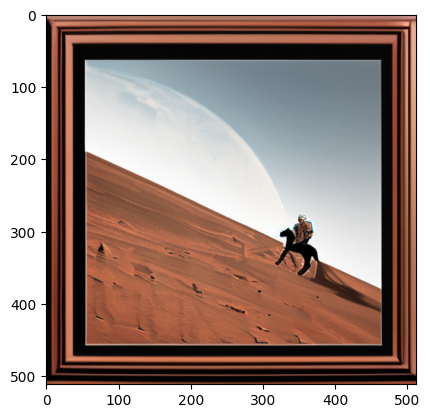

  0%|          | 0/100 [00:00<?, ?it/s]

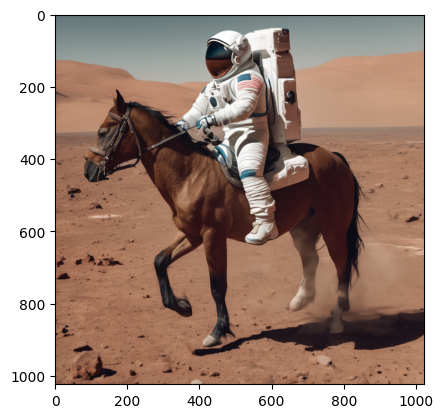

In [ ]:
output = compiled_pipe[(64, 64)]('a photo of an astronaut riding a horse on mars', height=512, width=512, num_inference_steps=100).images[0]

output.save("image.png")
image = mpimg.imread("image.png")
plt.imshow(image)
plt.show()

output = compiled_pipe[(128, 128)]('a photo of an astronaut riding a horse on mars', height=1024, width=1024, num_inference_steps=100).images[0]

output.save("image.png")
image = mpimg.imread("image.png")
plt.imshow(image)
plt.show()

In [5]:
"""
# --- Load all compiled models and run pipeline ---
COMPILER_WORKDIR_ROOT = 'sdxl_compile_dir_1024'
model_id = "stabilityai/stable-diffusion-xl-base-1.0"
text_encoder_filename = os.path.join(COMPILER_WORKDIR_ROOT, 'text_encoder/model.pt')
text_encoder_2_filename = os.path.join(COMPILER_WORKDIR_ROOT, 'text_encoder_2/model.pt')
decoder_filename = os.path.join(COMPILER_WORKDIR_ROOT, 'vae_decoder/model.pt')
unet_filename = os.path.join(COMPILER_WORKDIR_ROOT, 'unet/model.pt')
post_quant_conv_filename = os.path.join(COMPILER_WORKDIR_ROOT, 'vae_post_quant_conv/model.pt')

pipe = StableDiffusionXLPipeline.from_pretrained(model_id, torch_dtype=torch.float32)

# Load the compiled UNet onto two neuron cores.
pipe.unet = NeuronUNet(UNetWrap(pipe.unet))
device_ids = [0,1]
pipe.unet.unetwrap = torch_neuronx.DataParallel(torch.jit.load(unet_filename), device_ids, set_dynamic_batching=False)

# Load other compiled models onto a single neuron core.
pipe.vae.decoder = torch.jit.load(decoder_filename)
pipe.vae.post_quant_conv = torch.jit.load(post_quant_conv_filename)
pipe.text_encoder = TextEncoderOutputWrapper(torch.jit.load(text_encoder_filename), pipe.text_encoder)
pipe.text_encoder_2 = TextEncoderOutputWrapper(torch.jit.load(text_encoder_2_filename), pipe.text_encoder_2)
"""

'\n# --- Load all compiled models and run pipeline ---\nCOMPILER_WORKDIR_ROOT = \'sdxl_compile_dir_1024\'\nmodel_id = "stabilityai/stable-diffusion-xl-base-1.0"\ntext_encoder_filename = os.path.join(COMPILER_WORKDIR_ROOT, \'text_encoder/model.pt\')\ntext_encoder_2_filename = os.path.join(COMPILER_WORKDIR_ROOT, \'text_encoder_2/model.pt\')\ndecoder_filename = os.path.join(COMPILER_WORKDIR_ROOT, \'vae_decoder/model.pt\')\nunet_filename = os.path.join(COMPILER_WORKDIR_ROOT, \'unet/model.pt\')\npost_quant_conv_filename = os.path.join(COMPILER_WORKDIR_ROOT, \'vae_post_quant_conv/model.pt\')\n\npipe = StableDiffusionXLPipeline.from_pretrained(model_id, torch_dtype=torch.float32)\n\n# Load the compiled UNet onto two neuron cores.\npipe.unet = NeuronUNet(UNetWrap(pipe.unet))\ndevice_ids = [0,1]\npipe.unet.unetwrap = torch_neuronx.DataParallel(torch.jit.load(unet_filename), device_ids, set_dynamic_batching=False)\n\n# Load other compiled models onto a single neuron core.\npipe.vae.decoder = tor

In [6]:
"""
# Run pipeline
prompt = ["a photo of an astronaut riding a horse on mars",
          "sonic on the moon",
          "elvis playing guitar while eating a hotdog",
          "saved by the bell",
          "engineers eating lunch at the opera",
          "panda eating bamboo on a plane",
          "A digital illustration of a steampunk flying machine in the sky with cogs and mechanisms, 4k, detailed, trending in artstation, fantasy vivid colors",
          "kids playing soccer at the FIFA World Cup"
         ]

# First do a warmup run so all the asynchronous loads can finish
image_warmup = pipe(prompt[0]).images[0]

plt.title("Image")
plt.xlabel("X pixel scaling")
plt.ylabel("Y pixels scaling")

total_time = 0
for x in prompt:
    start_time = time.time()
    image = pipe(x).images[0]
    total_time = total_time + (time.time()-start_time)
    image.save("image.png")
    image = mpimg.imread("image.png")
    #clear_output(wait=True)
    plt.imshow(image)
    plt.show()
print("Average time: ", np.round((total_time/len(prompt)), 2), "seconds")
"""

'\n# Run pipeline\nprompt = ["a photo of an astronaut riding a horse on mars",\n          "sonic on the moon",\n          "elvis playing guitar while eating a hotdog",\n          "saved by the bell",\n          "engineers eating lunch at the opera",\n          "panda eating bamboo on a plane",\n          "A digital illustration of a steampunk flying machine in the sky with cogs and mechanisms, 4k, detailed, trending in artstation, fantasy vivid colors",\n          "kids playing soccer at the FIFA World Cup"\n         ]\n\n# First do a warmup run so all the asynchronous loads can finish\nimage_warmup = pipe(prompt[0]).images[0]\n\nplt.title("Image")\nplt.xlabel("X pixel scaling")\nplt.ylabel("Y pixels scaling")\n\ntotal_time = 0\nfor x in prompt:\n    start_time = time.time()\n    image = pipe(x).images[0]\n    total_time = total_time + (time.time()-start_time)\n    image.save("image.png")\n    image = mpimg.imread("image.png")\n    #clear_output(wait=True)\n    plt.imshow(image)\n    p